In [128]:
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx as nx

# Read data
## Coordonnées ville

In [96]:
ville_coord = pd.read_csv("../data/external/villes.csv")
ville_coord["pos_tuple"] = list(zip(ville_coord.lng, ville_coord.lat))
ville_coord.head()

,ville,lat,lng,pos_tuple
0,ALBERT-PICARDIE,49.97,2.69,"(2.69, 49.97)"
1,AGEN,44.17,0.59,"(0.59, 44.17)"
2,BORDEAUX,44.83,-0.80,"(-0.8, 44.83)"
3,BERGERAC,44.82,0.52,"(0.52, 44.82)"
4,LA-ROCHELLE,46.18,-1.20,"(-1.2, 46.18)"


In [97]:
pos = ville_coord.set_index("ville")["pos_tuple"].to_dict()

In [129]:
regions = gpd.read_file('../data/external/regions.geojson')

<AxesSubplot:>

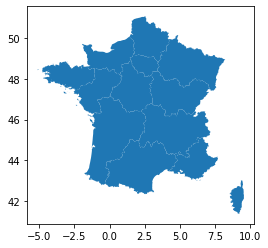

In [133]:
regions.drop(list(range(9, 14))).plot()

## Données aéroports

In [16]:
pax_graph = nx.Graph()
aeroports = pd.read_csv("../data/external/Eurostats_long.csv").drop("date", axis=1)
transport_mapping = {
    "PAS_CRD": "pax",
    "PAS_TRS": "pax_transit_direct",
    "PAS_TRF": "pax_transfert",
    "FRM_LD_NLD": "fret",
    "ACM": "mvt_all",
    "CACM": "mvt_com"
}
aeroports["tra_meas"] = aeroports["tra_meas"].map(transport_mapping)
aeroports.head()

,tra_meas,ville,n,annee,mois
0,mvt_all,AGEN,101,2010,1
1,mvt_all,AGEN,103,2010,2
2,mvt_all,AGEN,140,2010,3
3,mvt_all,AGEN,114,2010,4
4,mvt_all,AGEN,132,2010,5


In [17]:
aeroport_coord = pd.merge(aeroports, ville_coord, on="ville")
aeroport_coord.head()

,tra_meas,ville,n,annee,mois,lat,lng
0,mvt_all,AGEN,101,2010,1,44.17,0.59
1,mvt_all,AGEN,103,2010,2,44.17,0.59
2,mvt_all,AGEN,140,2010,3,44.17,0.59
3,mvt_all,AGEN,114,2010,4,44.17,0.59
4,mvt_all,AGEN,132,2010,5,44.17,0.59


## Build graph nodes

In [87]:
graph_mvt_all_dict = {}
for year in aeroport_coord["annee"].unique():
    aeroport_year = aeroport_coord.query(f"annee=={year}")
    graph_mvt_all_dict[year] = {}
    for month in aeroport_year["mois"].unique():
        aeroport_ym = aeroport_year.query(f"mois=={month}")
        aeroport_ym_pivot = aeroport_ym.pivot(index="ville", columns="tra_meas", values="n").fillna(0)
        aeroport_ym_pivot["s"] = aeroport_ym_pivot.sum(axis=1)
        aeroport_ym_pivot = aeroport_ym_pivot.query("s>0.1")
        
        cur_g = nx.Graph()
        cur_g.add_nodes_from(aeroport_ym_pivot.index.tolist())
        nx.set_node_attributes(cur_g, aeroport_ym_pivot.to_dict(orient="index"))
            
        graph_mvt_all_dict[year][month] = cur_g

# Read fluxes

In [101]:
fluxes = pd.read_csv("../data/external/DGAC_flux.csv", index_col=["id"])
fluxes.head()

,Annee,Origine,Destination,lat_Origine,lng_Origine,lat_Destination,lng_Destination,Dessertes,Pax_Total,Pax_reg,Pax_Non_rég,Fret_Total
id,,,,,,,,,,,,
1,2014,AJACCIO,BALE-MULHOUSE,41.92,8.8,47.59,7.53,206,27494,27355,139,0.0
2,2019,AJACCIO,BALE-MULHOUSE,41.92,8.8,47.59,7.53,382,57525,57466,59,0.0
3,2019,AJACCIO,BEAUVAIS,41.92,8.8,49.45,2.11,52,7010,7010,0,0.0
4,2009,AJACCIO,BORDEAUX,41.92,8.8,44.83,-0.80,149,11555,6062,5493,0.0
5,2014,AJACCIO,BORDEAUX,41.92,8.8,44.83,-0.80,539,45132,44835,297,0.0


In [149]:
graph_dict = {}
for year in fluxes["Annee"].unique():
    fluxes_year = fluxes.query(f"Annee=={year}")
    unique_airports = set(fluxes_year["Origine"].tolist() + fluxes_year["Destination"].tolist())
    cur_g = nx.Graph()
    cur_g.add_nodes_from(unique_airports)
    for _, row in fluxes_year.iterrows():
        cur_g.add_edge(row["Origine"], row["Destination"], 
                       **row[["Dessertes", "Pax_Total", "Pax_reg", "Pax_Non_rég", "Fret_Total"]].to_dict())
    graph_dict[year] = cur_g

# mvt plot

In [7]:
for year in tqdm(aeroport_coord["annee"].unique()):
    for month in tqdm(aeroport_coord["mois"].unique()):

        mvt_test = aeroport_coord.query(f"mois=={month} and annee=={year} and tra_meas=='mvt_all'")
        if len(mvt_test) == 0:
            continue
        
        fig = go.Figure()
        sizeref = mvt_test["n"].max() / (10 ** 2) / 6
        fig.add_trace(
            go.Scattergeo(
                lon = mvt_test['lng'],
                lat = mvt_test['lat'],
                text = mvt_test['ville'],
                marker = dict(
                    size = mvt_test['n'],
                    sizeref = sizeref,
                    sizemode = 'area',
                    color = "green",
                    line_color='rgb(40,40,40)',
                )
            )
        )
        fig.update_geos(fitbounds='locations', resolution=50, 
                        showcountries=True, countrycolor="white",
                        landcolor="lightgray", 
                        showocean=True, oceancolor="#C2C7CA",
                        showlakes=True, lakecolor="#C2C7CA")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, 
                          title=dict(text=f"<b>Total Mouvements {month:02d} {year}</b>",
                                     y=0.9,
                                     x=0.5))
        fig.write_image(f"../reports/mvt_all_{year}_{month:02d}.png")
        break
    break
    
fig.show()

In [8]:
for year in tqdm(aeroport_coord["annee"].unique()):
    for month in tqdm(aeroport_coord["mois"].unique()):

        mvt_test = aeroport_coord.query(f"mois=={month} and annee=={year} and tra_meas=='mvt_all'")
        if len(mvt_test) == 0:
            continue
        
        fig = go.Figure()
        sizeref = mvt_test["n"].max() / (10 ** 2) / 6
        fig.add_trace(
            go.Scattergeo(
                lon = mvt_test['lng'],
                lat = mvt_test['lat'],
                text = mvt_test['ville'],
                marker = dict(
                    size = mvt_test['n'],
                    sizeref = sizeref,
                    sizemode = 'area',
                    color = "green",
                    line_color='rgb(40,40,40)',
                )
            )
        )
        fig.update_geos(fitbounds='locations', resolution=50, 
                        showcountries=True, countrycolor="white",
                        landcolor="lightgray", 
                        showocean=True, oceancolor="#C2C7CA",
                        showlakes=True, lakecolor="#C2C7CA")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, 
                          title=dict(text=f"<b>Total Mouvements {month:02d} {year}</b>",
                                     y=0.9,
                                     x=0.5))
        fig.write_image(f"../reports/figures/mvt_all_{year}_{month:02d}.png")


In [159]:
for year, cur_g in tqdm(graph_dict.items()):
    f, ax = plt.subplots(figsize=(15,12))

    weights = np.array([cur_g[u][v]['Pax_Total'] for u,v in cur_g.edges])
    weights = weights / weights.max() * 20

    regions.drop(list(range(9, 14))).boundary.plot(ax=ax, color="lightgray", linewidth=1)
    nx.draw_networkx(cur_g, pos, width=weights, ax=ax, edge_color=(1,0,0, 0.5))
    plt.title(f"Flux total passagers {year}", {'fontsize': 20, 'fontweight' : "bold"})
    plt.tight_layout()
    plt.savefig(f"../reports/figures/flux_{year}.png")
    plt.close(f)

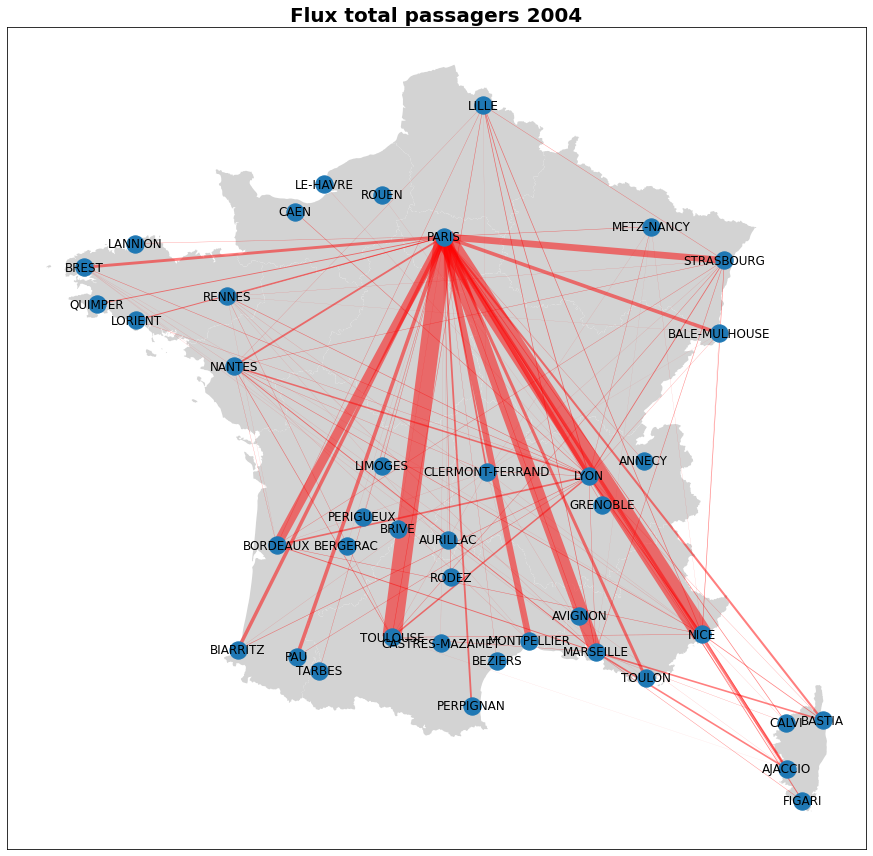

In [162]:
    f, ax = plt.subplots(figsize=(15,12))

    weights = np.array([cur_g[u][v]['Pax_Total'] for u,v in cur_g.edges])
    weights = weights / weights.max() * 20

    regions.drop(list(range(9, 14))).plot(ax=ax, color="lightgray", linewidth=1)
    nx.draw_networkx(cur_g, pos, width=weights, ax=ax, edge_color=(1,0,0, 0.5))
    plt.title(f"Flux total passagers {year}", {'fontsize': 20, 'fontweight' : "bold"})
    plt.tight_layout()